In [1]:
%pylab
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [69]:
from matplotlib import animation
from IPython.display import HTML # requires ffmpeg

In [38]:
import pandas as pd
import os
import sqlalchemy as sql #create_engine
import photutils

In [3]:
from gPhoton import PhotonPipe
from gPhoton.MCUtils import angularSeparation, print_inline

In [4]:
import gfcat_utils as gfu

#### Create some functions for searching the SQLite database

In [5]:
def query(query,catdbfile='catalog.db'):
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = engine.execute(query).fetchall()
    engine.dispose()
    return out

def conesearch(skypos,match_radius=0.005,catdbfile='catalog.db'):
    out = np.array(query(f"SELECT eclipse, id, ra, dec, xcenter, ycenter FROM gfcat WHERE ra >= {skypos[0]-match_radius} AND ra <={skypos[0]+match_radius} AND dec>= {skypos[1]-match_radius} AND dec<={skypos[1]+match_radius}"))
    dist_ix = np.where(angularSeparation(skypos[0],skypos[1],
                                         out[:,2],out[:,3])<=match_radius)
    return pd.DataFrame({'eclipse':np.array(out[:,0][dist_ix],dtype='int16'),
                         'id':np.array(out[:,1][dist_ix],dtype='int16'),
                         'ra':out[:,2][dist_ix],
                         'dec':out[:,3][dist_ix],
                         'xcenter':out[:,4][dist_ix],
                         'ycenter':out[:,5][dist_ix]})

#### Query observation data for GJ65.

In [6]:
%time uvceti = conesearch((24.76279, -17.94948)) # GJ65 aka "UV Ceti"
print(f'There are {len(uvceti)} GJ65 observations.')
print(f'We will use the first one: e{(eclipse:=int(uvceti.iloc[0].eclipse))}')

CPU times: user 6.5 ms, sys: 1.66 ms, total: 8.17 ms
Wall time: 7.32 ms
There are 9 GJ65 observations.
We will use the first one: e13656


#### Download the raw data from MAST

In [7]:
data_directory='../data' # Relative path to the local disk location that data should be written
band = 'NUV' # NUV has ~10x high countrates than FUV for most types of sources

In [8]:
raw6file = gfu.download_raw6(eclipse,band,data_directory=data_directory)

../data/e13656/e13656-nd-raw6.fits.gz already exists.
	Use keyword `force` to re-download.


#### Calibrate the data

In [9]:
photonfile = '{d}/e{e}/e{e}-{b}d.h5'.format(
        d=data_directory, e=eclipse, b='n' if band=='NUV' else 'f') # output filename
print(f'Photon data file: {photonfile}')
if not os.path.exists(photonfile):
    PhotonPipe.photonpipe(raw6file[:-13],band,raw6file=raw6file,verbose=2)

Photon data file: ../data/e13656/e13656-nd.h5


In [11]:
xcalfilename = photonfile.replace('.h5','-xcal.h5')
print(f'E[x]tended photon data file: {xcalfilename}')
if not os.path.exists(xcalfilename):
    events = gfu.calibrate_photons(photonfile,band)
    if len(events):
        print('Writing {xcalfilename}'.format(xcalfilename=xcalfilename))
        os.remove(xcalfilename) # Warning re: append. Important that file doesn't already exist!
        with pd.HDFStore(xcalfilename) as store:
            store.append('events',events)
    else:
        raise('There is no valid data in this visit and everything after will fail.')

E[x]tended photon data file: ../data/e13656/e13656-nd-xcal.h5
Writing ../data/e13656/e13656-nd-xcal.h5


#### Create full-depth images and 120s movies
This is the biggest processing bottleneck. It will hit CPU and memory hard, and little has been done to mitigate that. 32Gb of onboard memory is recommended as a minimum. For unusually bright fields, 128Gb is probably needed.

In [22]:
cntfilename = photonfile.replace(".h5", "-cnt.fits.gz")
movfilename = photonfile.replace(".h5", "-mov.fits.gz") # Not used here
# This is the biggest processing bottleneck... will hit CPU and memory hard!
if not os.path.exists(cntfilename) and not os.path.exists(moviefilename):
    %time gfu.make_images(eclipse,band,data_directory=data_directory)

Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.


<ipython-input-27-c18103b4d35d>:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(cntmap), cmap="Greys", origin="lower")
<ipython-input-27-c18103b4d35d>:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
<ipython-input-27-c18103b4d35d>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish



15 images frames.

Time range: [[816379178.995, 816380892.99]]

Exposure time: [1529.69847911154]

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 24.707145171748  -17.96955374296633  
CRPIX : 1600.5  1600.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.000416666666666667  0.000416666666666667  
NAXIS : 0  0


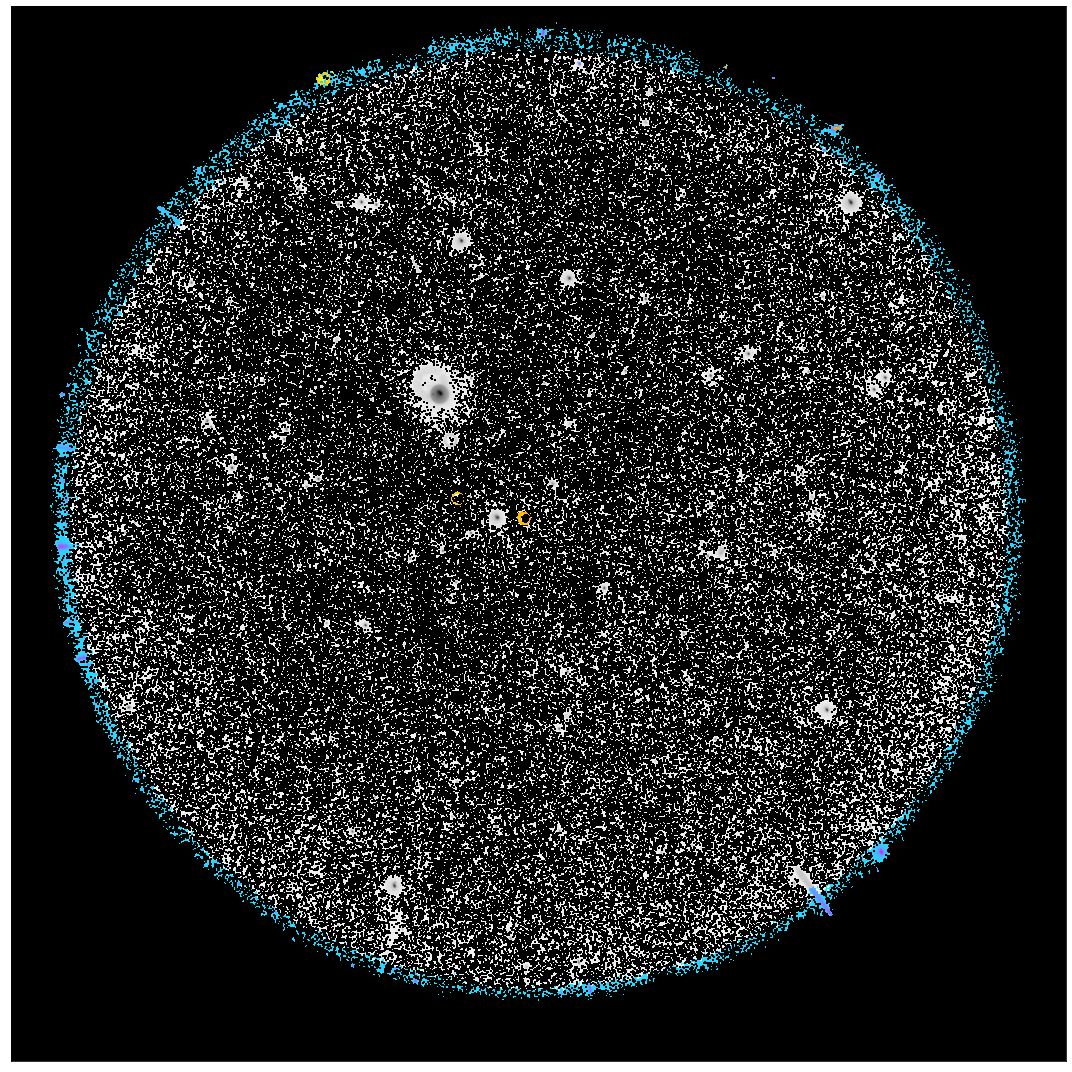

In [27]:
cntmap, flagmap, edgemap, wcs, tranges, exptimes = gfu.read_image(cntfilename)
plt.figure(figsize=(15, 15))
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(np.log10(cntmap), cmap="Greys", origin="lower")
plt.imshow(np.log10(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish
plt.xticks([])
plt.yticks([])
plt.tight_layout()

print(f'\n{len(movmap)} images frames.\n')
print(f'Time range: {tranges}\n')
print(f'Exposure time: {exptimes}\n')
print(f'{wcs}')

Opened ../data/e13656/e13656-nd-mov.fits.gz
	Parsed file header.


<ipython-input-48-dcdbc63d264a>:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(movmap[0]), cmap="Greys", origin="lower")
<ipython-input-48-dcdbc63d264a>:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
<ipython-input-48-dcdbc63d264a>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish



15 images frames.

Time ranges: [[816379178.995, 816379298.995], [816379298.995, 816379418.995], [816379418.995, 816379538.995], [816379538.995, 816379658.995], [816379658.995, 816379778.995], [816379778.995, 816379898.995], [816379898.995, 816380018.995], [816380018.995, 816380138.995], [816380138.995, 816380258.995], [816380258.995, 816380378.995], [816380378.995, 816380498.995], [816380498.995, 816380618.995], [816380618.995, 816380738.995], [816380738.995, 816380858.995], [816380858.995, 816380978.995]]

Exposure times: [99.89534387874362, 108.2948546857536, 108.5475370233458, 100.9936855071996, 108.6073180701725, 108.9587637063089, 109.0084534329608, 109.0391590492263, 109.0225789172311, 108.9881125104146, 108.8282169828098, 104.2939701664094, 108.4074025359119, 108.2169646598949, 28.59566196115353]

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 24.707145171748  -17.96955374296633  
CRPIX : 1600.5  1600.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0

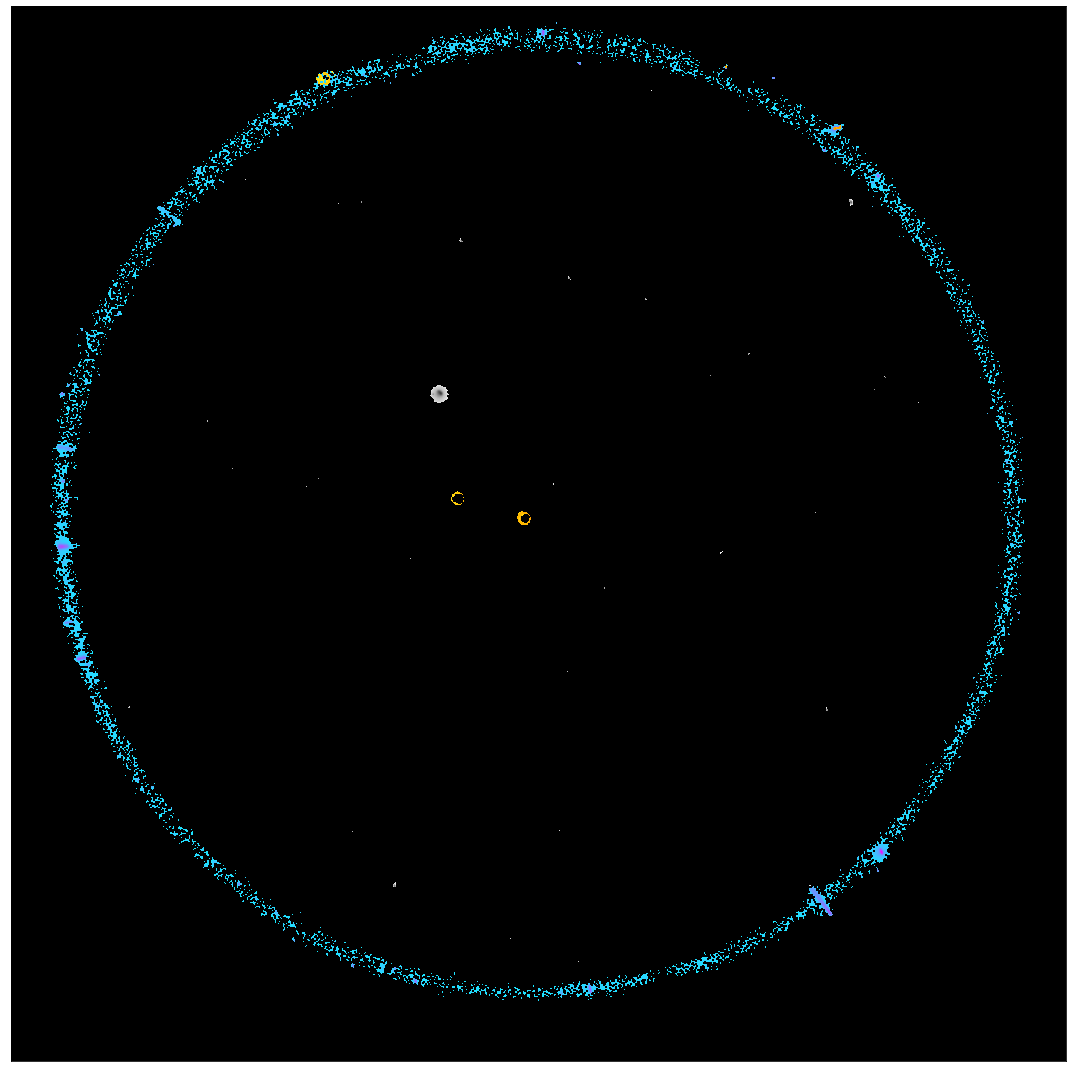

In [48]:
movmap, _, _, wcs, tranges, exptimes = gfu.read_image(movfilename)
plt.figure(figsize=(15, 15))
plt.imshow(np.zeros(np.shape(movmap[0])),cmap="Greys_r")
plt.imshow(np.log10(movmap[0]), cmap="Greys", origin="lower")
plt.imshow(np.log10(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish
plt.xticks([])
plt.yticks([])
plt.tight_layout()
    
print(f'\n{len(movmap)} images frames.\n')
print(f'Time ranges: {tranges}\n')
print(f'Exposure times: {exptimes}\n')
print(f'{wcs}')

<ipython-input-87-30b36ddd0c10>:9: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(frame), cmap="Greys", origin="lower", animated=True),
<ipython-input-87-30b36ddd0c10>:10: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap), origin="lower", cmap="cool", animated=True),
<ipython-input-87-30b36ddd0c10>:11: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia", animated=True),


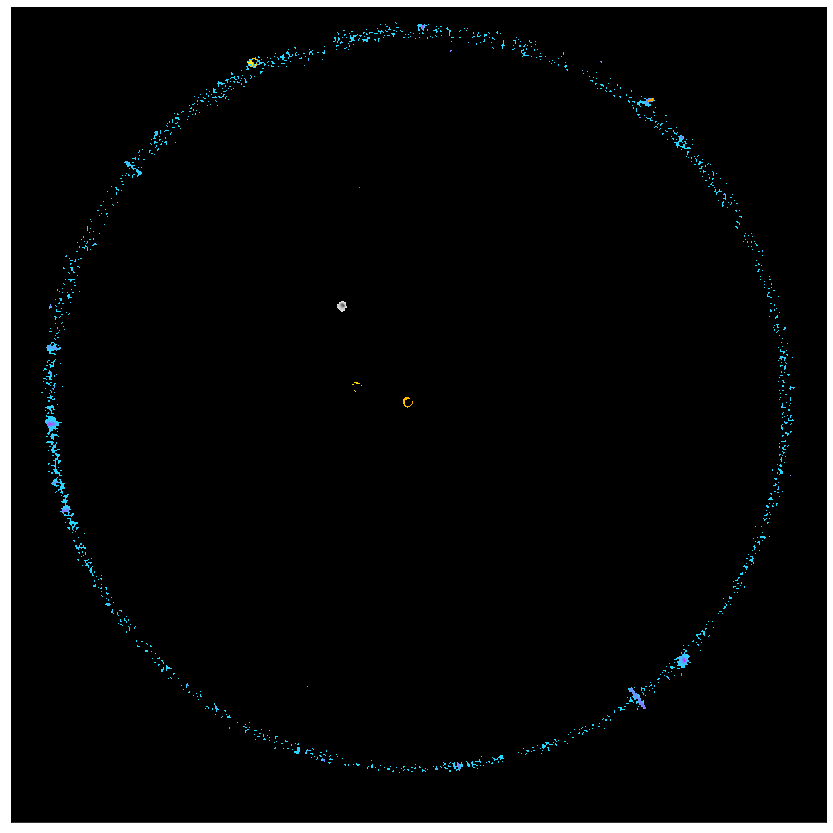

In [87]:
fig = plt.figure(figsize=(15,15))
plt.xticks([])
plt.yticks([])

ims = []
for frame in movmap:
    ims.append([
        plt.imshow(np.zeros(np.shape(frame)),cmap="Greys_r", animated=True),
        plt.imshow(np.log10(frame), cmap="Greys", origin="lower", animated=True),
        plt.imshow(np.log10(edgemap), origin="lower", cmap="cool", animated=True),
        plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia", animated=True),
    ])
    
ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat=True)

HTML(ani.to_html5_video())
#HTML(ani.to_jshtml())

#NOTE: I don't know why this is displaying an image under the movie or how to make it stop.

#### Generate an image stamp of the target source

<ipython-input-36-37062652de1d>:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(cntmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Greys_r')
<ipython-input-36-37062652de1d>:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool')
<ipython-input-36-37062652de1d>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia')


([], [])

/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


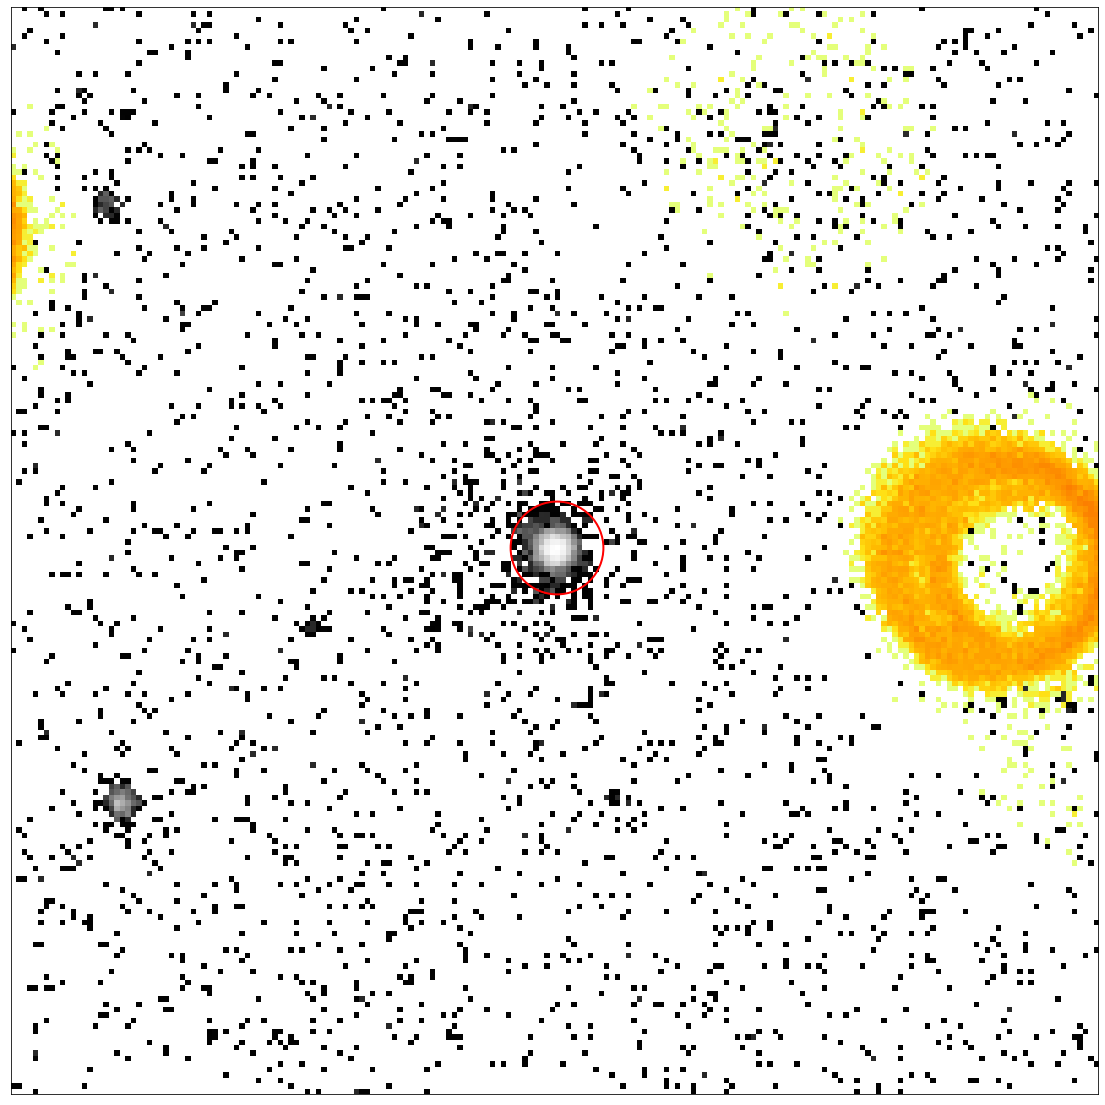

In [36]:
sz = 100 # half height / width of stamp in pixels
x,y = int(np.round(uvceti.iloc[0].xcenter)),int(np.round(uvceti.iloc[0].ycenter))
plt.figure(figsize=(20, 20))
plt.imshow(np.log10(cntmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Greys_r')
plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool')
plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia')
# Now overplot the aperture
photutils.CircularAperture([sz,sz], r=8.533333333333326).plot(color='red', lw=2, alpha=1)
plt.xticks([])
plt.yticks([])

#### And generate an movie stamp. Why not? It's the future.

<ipython-input-90-9c3a1b24482d>:11: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(frame[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Greys_r', animated=True),
<ipython-input-90-9c3a1b24482d>:12: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool', animated=True),
<ipython-input-90-9c3a1b24482d>:13: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia', animated=True),
/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/cm/opt/miniconda3/lib/python3.8/sit

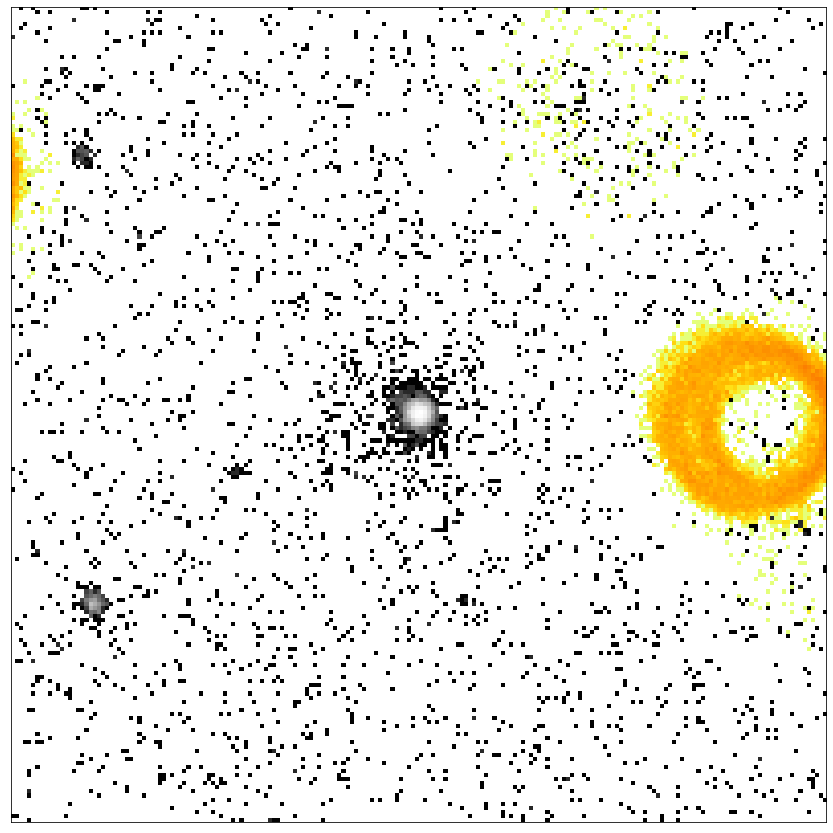

In [90]:
fig = plt.figure(figsize=(15,15))
plt.xticks([])
plt.yticks([])

sz = 100 # half height / width of stamp in pixels
x,y = int(np.round(uvceti.iloc[0].xcenter)),int(np.round(uvceti.iloc[0].ycenter))

ims = []
for frame in movmap:
    ims.append([
        plt.imshow(np.log10(frame[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Greys_r', animated=True),
        plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool', animated=True),
        plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia', animated=True),
        #photutils.CircularAperture([sz,sz], r=8.533333333333326).plot(color='red', lw=2, alpha=1),
    ])
    
ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat=True)

HTML(ani.to_html5_video())
#HTML(ani.to_jshtml())

#NOTE: I don't know why this is displaying an image under the movie or how to make it stop.